# CarbonLoop Part 2

In [1]:
import os
from util_functions import *
import yaml
import json
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Import ACT libraries
if "/home/workspace/ACT-tutorial" not in sys.path:
    sys.path.append("/home/workspace/ACT-tutorial")
if not os.path.exists("/home/workspace/ACT-tutorial"):
    raise FileNotFoundError(f"Provided path does not exist: /home/workspace/ACT-tutorial")
from dram_model import Fab_DRAM
from hdd_model import Fab_HDD
from ssd_model import Fab_SSD
from logic_model  import Fab_Logic

### 1. Read Output from Timeloop+Accelergy and Save in Yaml Files

In [2]:
## USER INPUT
mode = 'gb'

if mode == 'gb':
    sweep_list = [x for x in range(4000,12001,500)]
elif mode == 'pe':
    sweep_list = [x for x in range(20,81,4)]

In [3]:
# Generate arch dirctory list
arch_type = 'eyeriss_like'
arch = []
for sweep in sweep_list:
    arch.append(arch_type+'_'+mode+'_'+str(sweep))

for arch_name in arch:
    tl_output_path = "outputs-"+mode+"/"+arch_name
    tl_file_name = 'timeloop-mapper.stats.txt'
    output_yaml = os.path.join(tl_output_path, 'timeloop_summary.yaml')
    
    layer_dirs = search_directories(tl_output_path)
    dram_weight_caps = []
    energy = []
    cycles = []
    dram_inout_max = 0
    chip_area_max = 0
    
    for layer_dir in layer_dirs[1:]:
        if 'eyeriss_like' in layer_dir.split('/')[-1]:
            file_path = os.path.join(layer_dir, tl_file_name)
            
            dram_caps = extract_dram_utilized_capacity(file_path)
            if (dram_caps[0]+dram_caps[1]) > dram_inout_max:
                dram_inout_max = dram_caps[0]+dram_caps[1]
            dram_weight_caps.append(dram_caps[2])
            
            chip_area = extract_total_chip_area(file_path)
            if chip_area > chip_area_max:
                chip_area_max = chip_area
                
            energy.append(extract_total_energy(file_path))
            cycles.append(extract_total_cycles(file_path))
    
    total_cap = dram_inout_max + sum(dram_weight_caps)
    total_area = chip_area_max
    total_energy = sum(energy)
    total_cycles = sum(cycles)

    ### Write to yaml file ###
    save_to_yaml(output_yaml, total_cap, total_area, total_energy, total_cycles)

### 2. Import data from yaml files

In [4]:
total_energy_kWh_list = []
total_area_cm2_list = []
total_cap_GB_list = []
total_cycles_list = []
for arch_name in arch:
    yaml_path = "outputs-"+mode+"/"+arch_name+'/timeloop_summary.yaml'
    with open(yaml_path, 'r') as f:
        summary = yaml.safe_load(f)
    total_cap_GB_list.append(summary['dram_utilized_capacity'] /1000000000)
    total_area_cm2_list.append(summary['total_chip_area_um2'] / 100000000)
    total_energy_kWh_list.append(summary['total_energy_uJ'] / (3600*10**9))
    total_cycles_list.append(summary['total_cycles'])

### 2. Calculate Carbon Footprint using ACT

In [5]:
## USER INPUT
# Assume parameters
use_ci     = "loc_usa"
Kr         = 0.15          # kg CO2
n_inf      = 1500          # per day
LT         = 3             # years
clock_freq = 200           # MHz
T          = LT
cores      = 32

# Initialize ACT components
processor = Fab_Logic(process_node=28, gpa="95", fab_carbon_intensity="loc_taiwan", use_carbon_intensity="loc_usa",debug=False, fab_yield=0.8)
DRAM      = Fab_DRAM(config="lpddr4",fab_yield=0.8)
N         = 2

In [6]:
total_latency_list = []
cf_package_list = []
cf_processor_list = []
cf_DRAM_list = []
cf_embodied_list = []
cf_dis_embodied_list = []
cf_operational_list = []
cf_final_list = []

for total_cap, total_area, total_energy, total_cycles in zip(total_cap_GB_list, total_area_cm2_list, total_energy_kWh_list, total_cycles_list):
    # Input parameters to ACT
    total_latency_list.append((1/(clock_freq*1000000))*total_cycles)
    processor.set_area(total_area)
    DRAM.set_capacity(total_cap)
    
    # Calculate Carbon Footprint (kg Co2)
    cf_package_list.append(N * Kr / cores)
    cf_processor_list.append(processor.get_carbon() / 1000.)
    cf_DRAM_list.append(DRAM.get_carbon() / 1000.)
    cf_embodied_list.append(cf_package_list[-1] + cf_processor_list[-1] + cf_DRAM_list[-1])
    cf_dis_embodied_list.append(T/LT*cf_embodied_list[-1])
    cf_operational_list.append(processor.get_use_ci() * n_inf*365*LT * total_energy / 1000.)
    cf_final_list.append(cf_operational_list[-1] + cf_dis_embodied_list[-1])

### 3. Visualize the Result

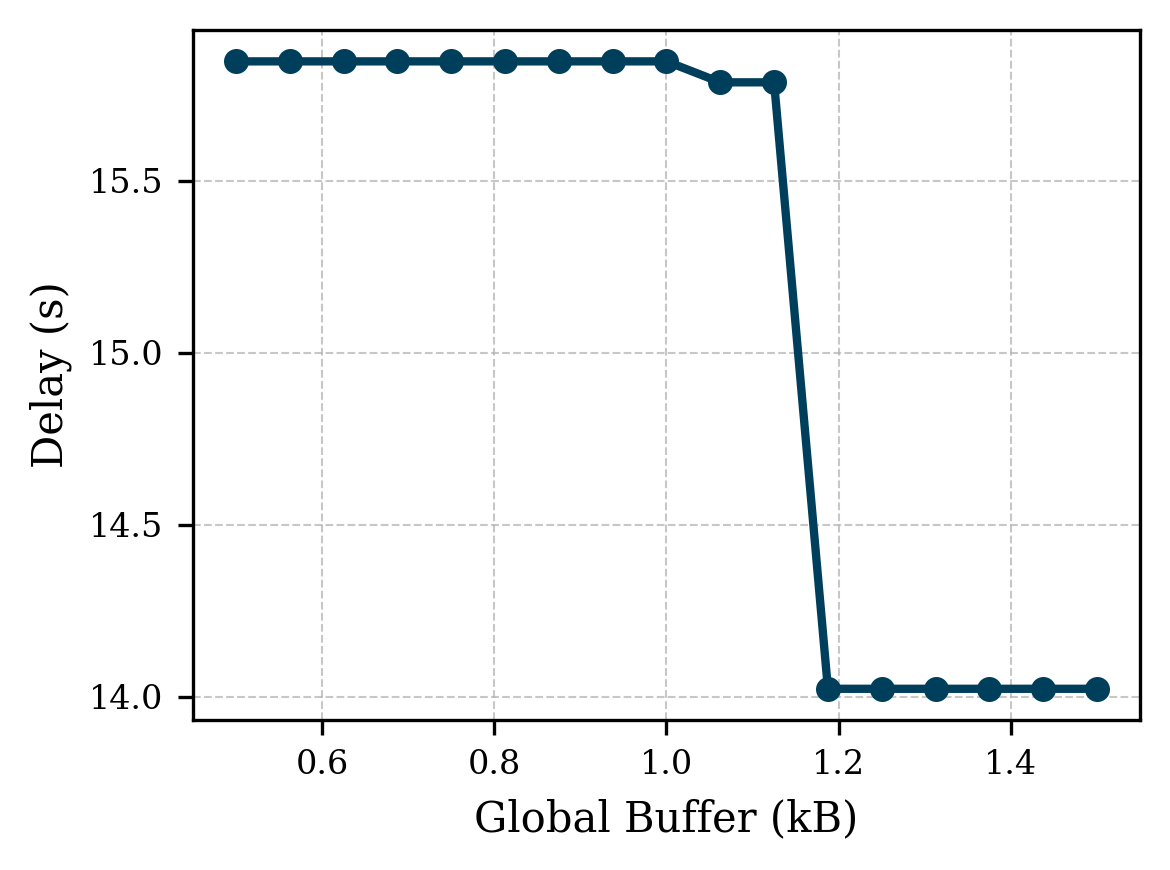

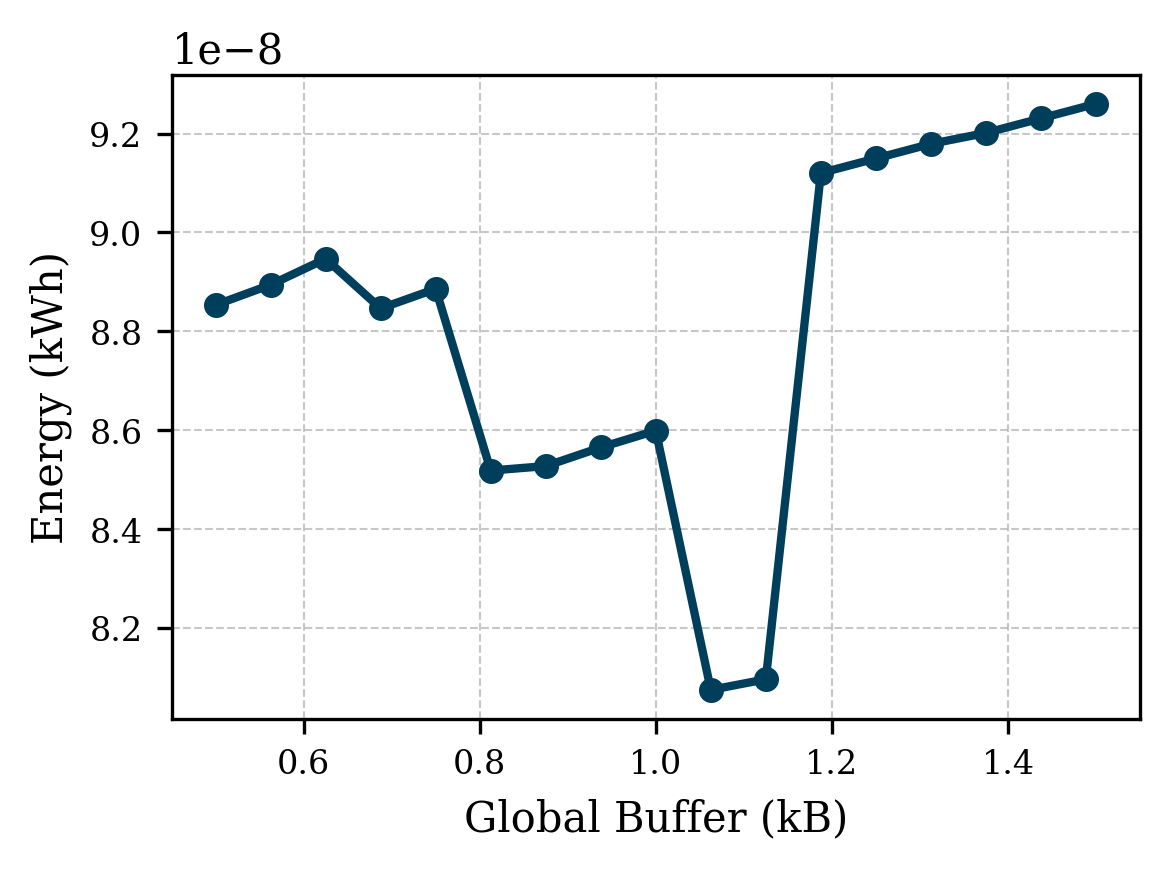

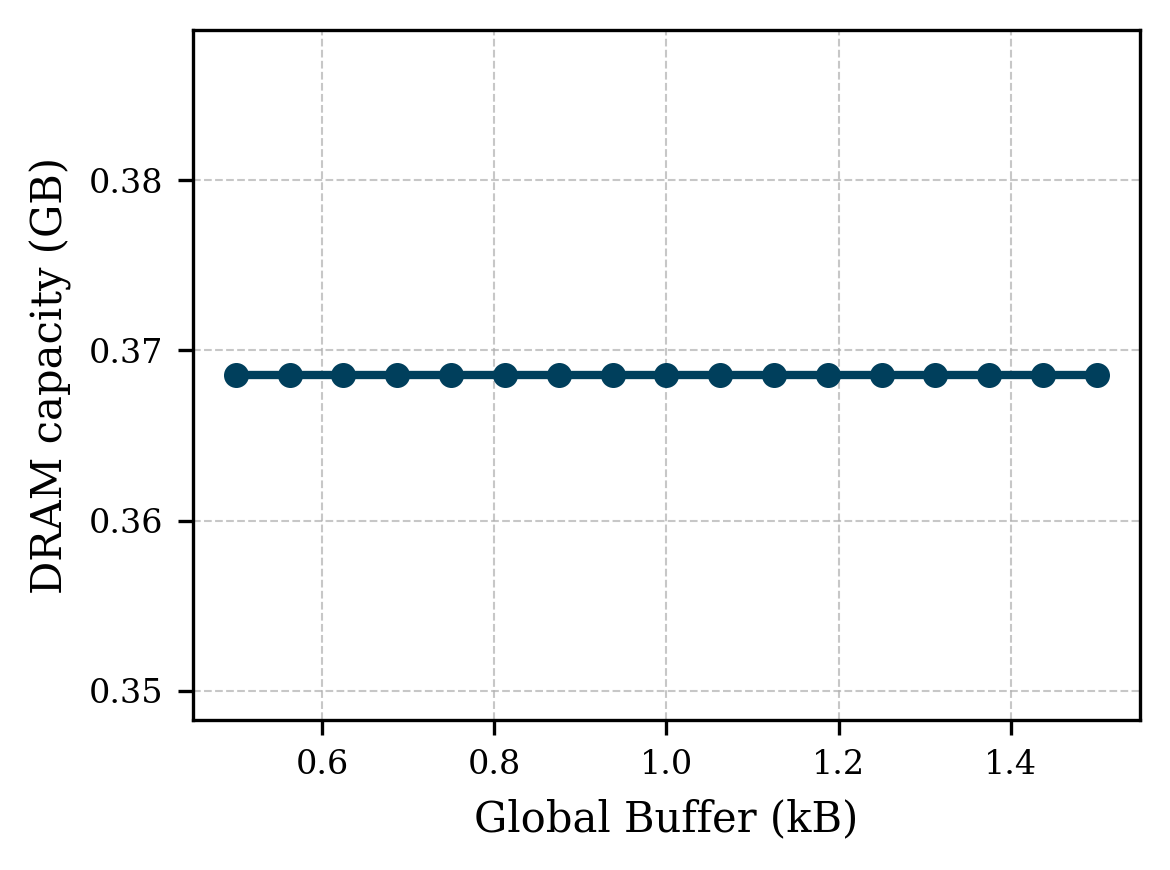

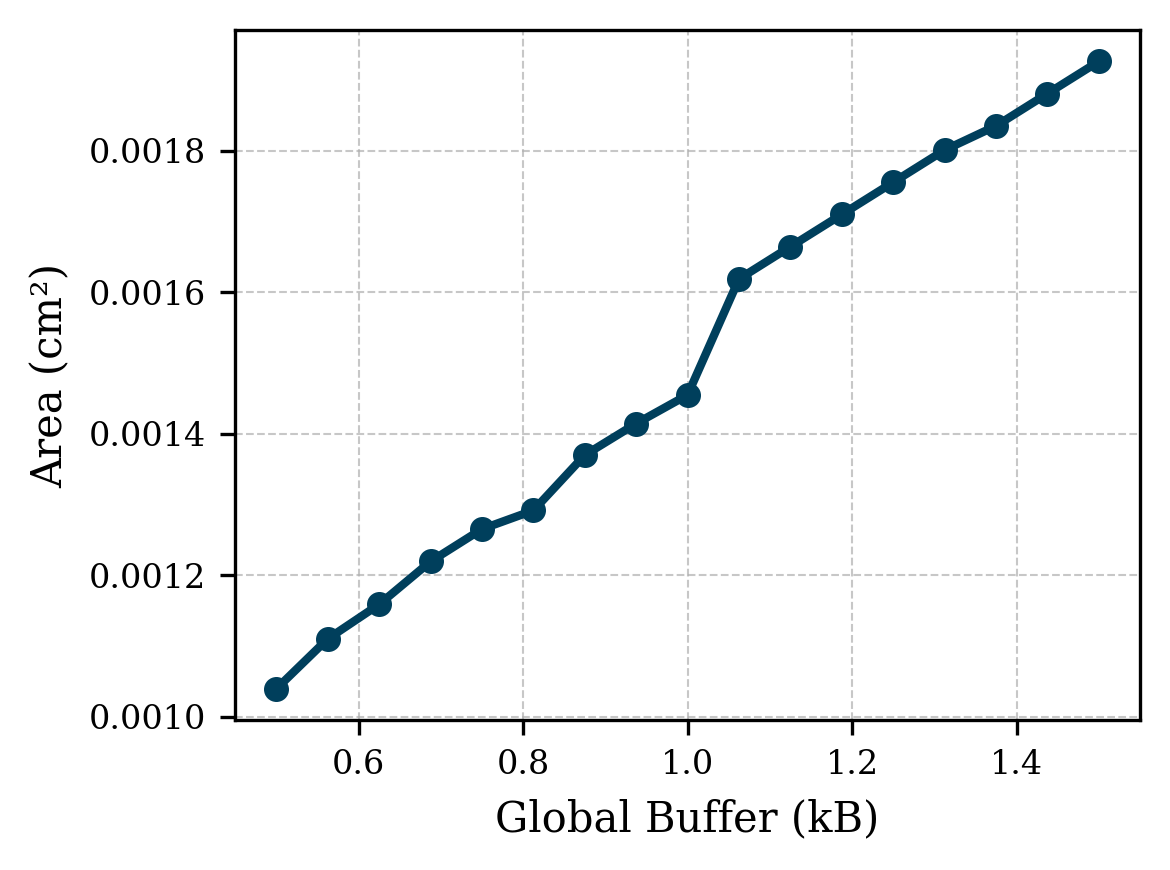

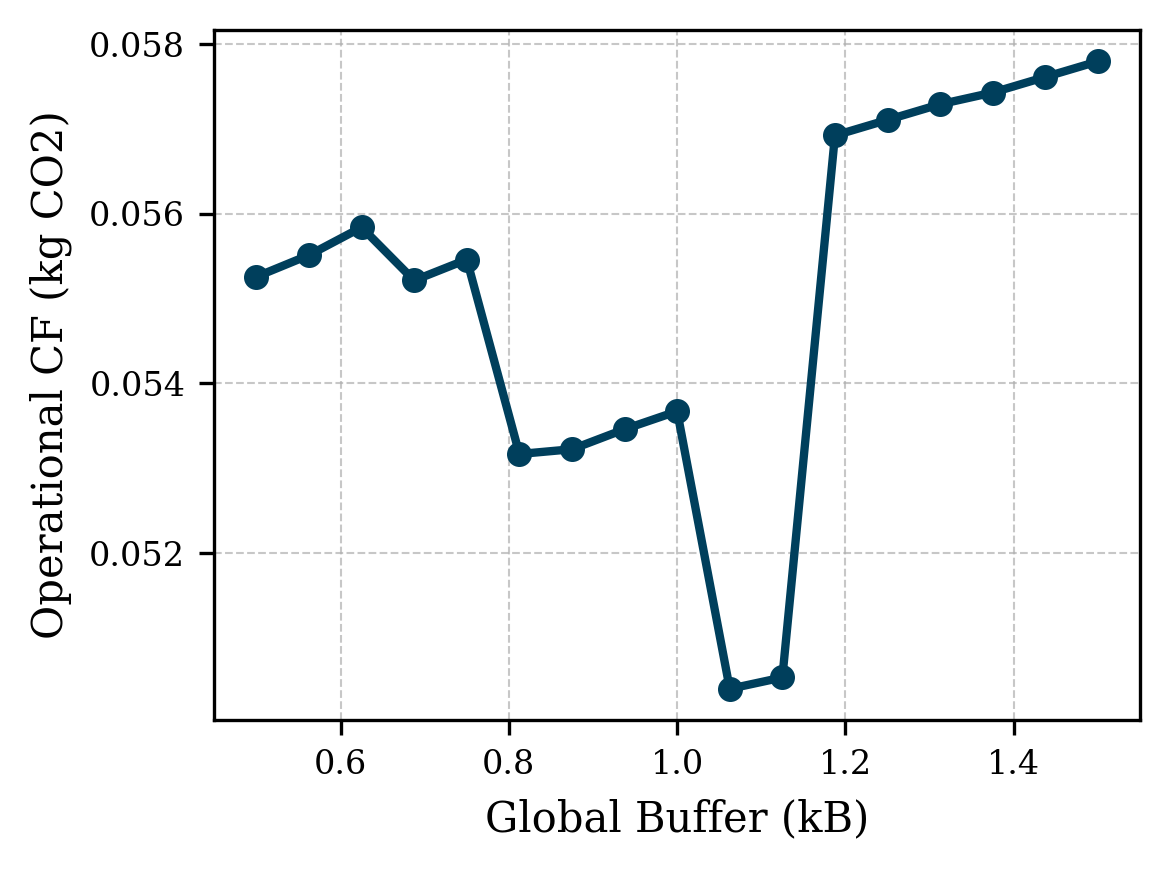

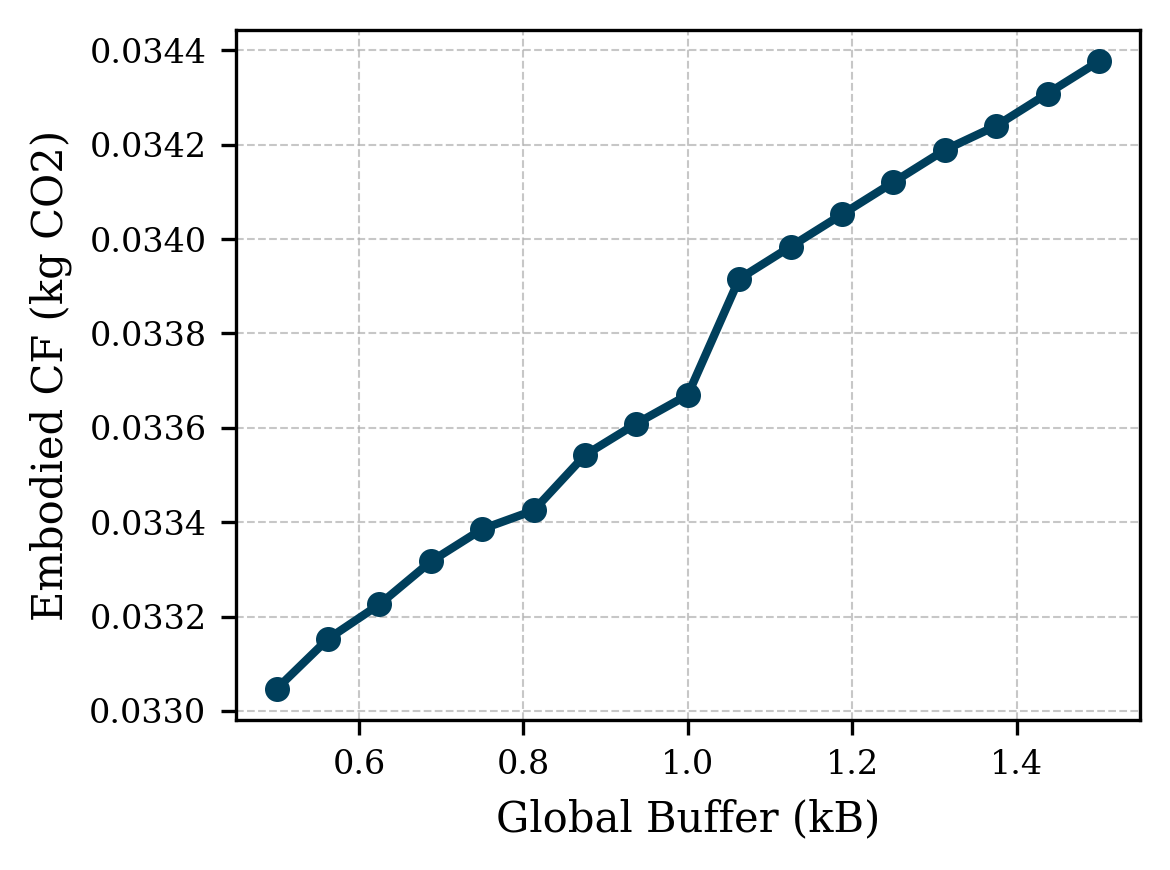

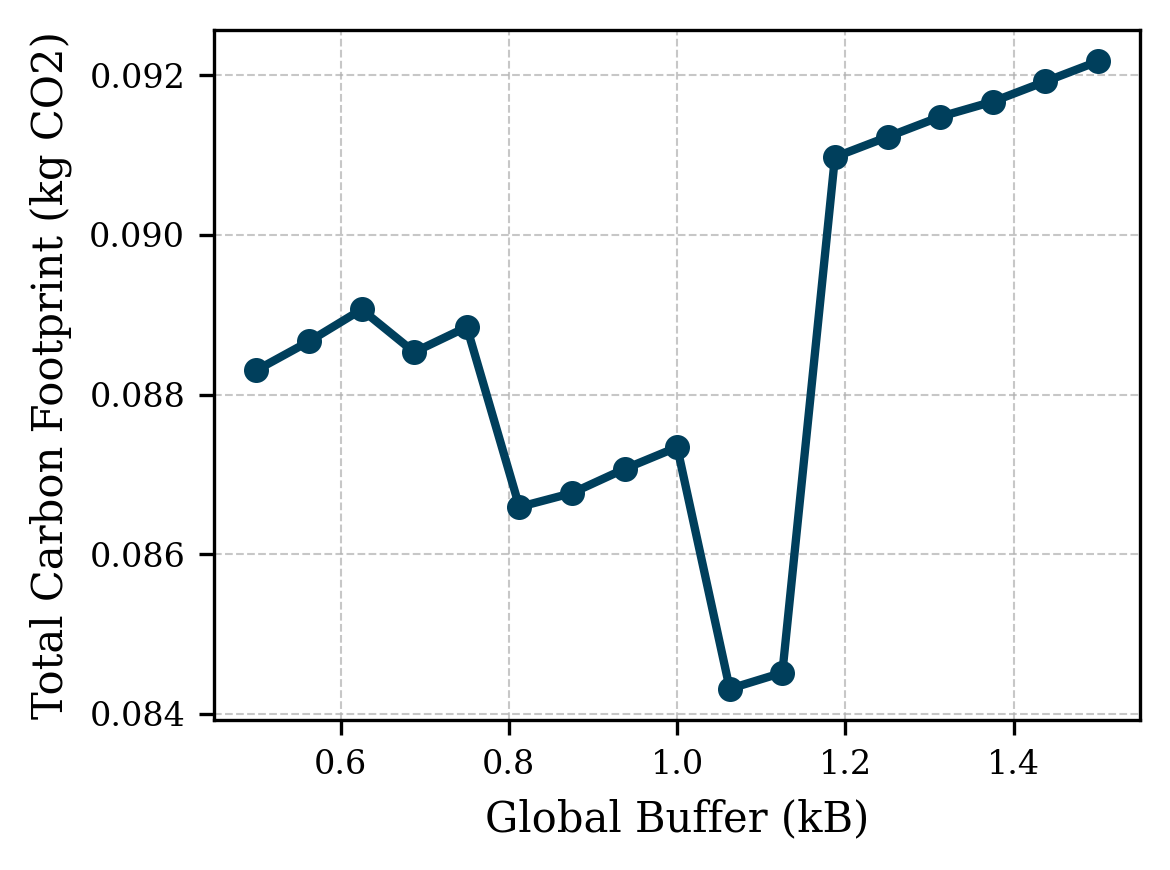

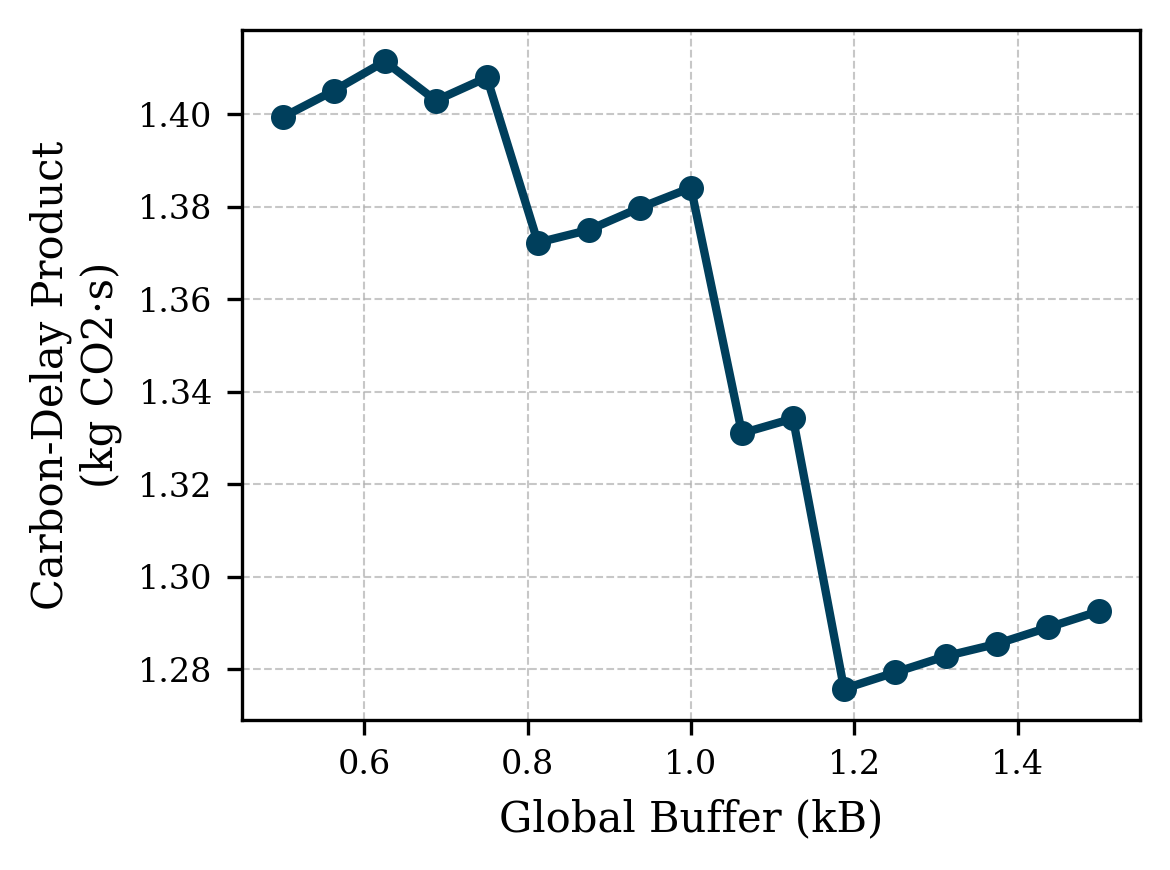

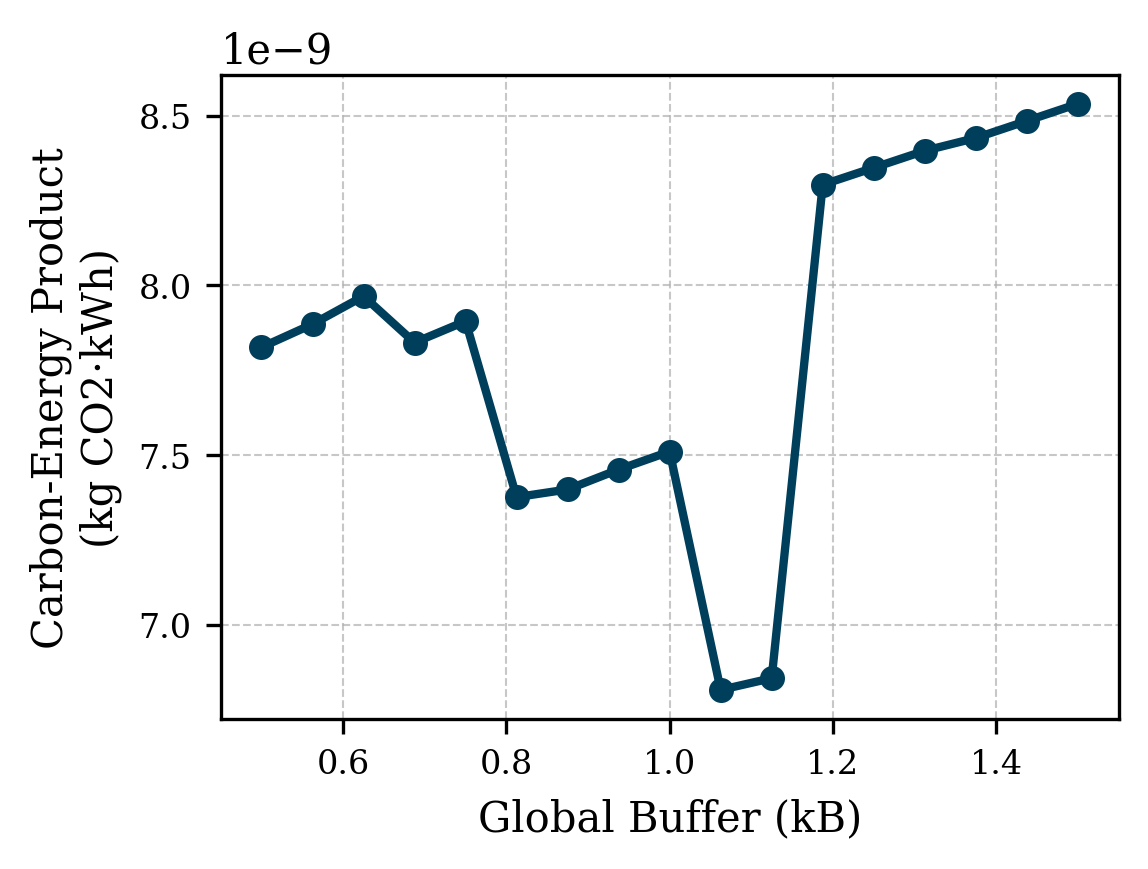

In [7]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif', 'Computer Modern Roman']

if not os.path.exists('./figures'):
    os.makedirs('./figures')

if mode == 'gb':
    x = np.array(sweep_list)/8000
    line_color = '#003f5c'
    xlabel = "Global Buffer (kB)"
elif mode == 'pe':
    x = sweep_list
    line_color = '#4682B4'
    xlabel = "Number of PEs"

def plot_figure(y, ylabel):
    plt.figure(figsize=(4, 3), dpi=300)
    plt.plot(x, y, marker='o', markersize=5, linewidth=2, color=line_color)

    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"figures/fig_x_{mode}_{'_'.join(ylabel.split('(')[0][:-1].lower().split(' '))}.pdf", format='pdf')
    plt.show()
    plt.close()

CEP_list = []
CDP_list = []
for i in range(len(x)):
    CEP_list.append(cf_final_list[i]*total_energy_kWh_list[i])
    CDP_list.append(cf_final_list[i]*total_latency_list[i])

plot_figure(total_latency_list, "Delay (s)")
plot_figure(total_energy_kWh_list, "Energy (kWh)")
plot_figure(total_cap_GB_list, "DRAM capacity (GB)")
plot_figure(total_area_cm2_list, "Area (cm²)")

plot_figure(cf_operational_list, "Operational CF (kg CO2)")
plot_figure(cf_embodied_list, "Embodied CF (kg CO2)")
plot_figure(cf_final_list, "Total Carbon Footprint (kg CO2)")

plot_figure(CDP_list, "Carbon-Delay Product\n(kg CO2⋅s)")
plot_figure(CEP_list, "Carbon-Energy Product\n(kg CO2⋅kWh)")